In [9]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [10]:
# Import some python libraries
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import intake
import climpred

<IPython.core.display.Javascript object>

In [11]:
assert int(climpred.__version__.replace('.','')[:3])>=211

<IPython.core.display.Javascript object>

In [12]:
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
options = gateway.cluster_options()
options.worker_cores = 4
cluster = gateway.new_cluster(cluster_options=options)

cluster.scale(16) # scale up if more performance required
from time import sleep
sleep(10)

<IPython.core.display.Javascript object>

In [13]:
client = cluster.get_client()
client.restart()
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.673871021baf47d2aad66a72848fdace Dashboard: /services/dask-gateway/clusters/prod.673871021baf47d2aad66a72848fdace/status,Cluster Workers: 2 Cores: 8 Memory: 8.59 GB


<IPython.core.display.Javascript object>

# setup `intake-esm`
intake-esm.readthedocs.io/

In [14]:
col = intake.open_esm_datastore("https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json")

<IPython.core.display.Javascript object>

In [15]:
variable_id = 'tas'
table_id = 'Amon'
source_id = 'CESM1-1-CAM5-CMIP5'

<IPython.core.display.Javascript object>

# Get hindcast
Boer, G. J., D. M. Smith, C. Cassou, F. Doblas-Reyes, G. Danabasoglu, B. Kirtman, Y. Kushnir, et al. “The Decadal Climate Prediction Project (DCPP) Contribution to CMIP6.” Geosci. Model Dev. 9, no. 10 (October 25, 2016): 3751–77. https://doi.org/10/f89qdf.

In [16]:
cat_cmip = col.search(experiment_id=['dcppA-hindcast'],
                 table_id=table_id,       
                 variable_id=variable_id,
                 source_id=source_id,
                     )
cat_cmip.df['dcpp_init_year'] = cat_cmip.df.dcpp_init_year.astype(int)
#cat_cmip

<IPython.core.display.Javascript object>

In [17]:
members = sorted(list(cat_cmip.df.member_id.unique()))[:5]
inits = list(np.arange(1970,2010))

<IPython.core.display.Javascript object>

In [18]:
cat_cmip = col.search(experiment_id=['dcppA-hindcast'],
                 table_id=table_id,       
                 variable_id=variable_id,
                 source_id=source_id,
                 member_id = members,
                 dcpp_init_year=inits
                     )
cat_cmip.df['dcpp_init_year'] = cat_cmip.df.dcpp_init_year.astype(int)

<IPython.core.display.Javascript object>

In [19]:
def pre(ds,var=variable_id):
    ds['time']=np.arange(1,1+ds.time.size)
    return ds

<IPython.core.display.Javascript object>

In [20]:
%%time
dset_dict = cat_cmip.to_dataset_dict(zarr_kwargs={'consolidated': True},preprocess=pre,cdf_kwargs={'decode_times':False,
                                                 'chunks':{'time':-1}})
list(dset_dict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


CPU times: user 2.08 s, sys: 71.6 ms, total: 2.15 s
Wall time: 11.6 s


['DCPP.NCAR.CESM1-1-CAM5-CMIP5.dcppA-hindcast.Amon.gn']

<IPython.core.display.Javascript object>

In [21]:
from climpred.preprocessing.shared import rename_to_climpred_dims

<IPython.core.display.Javascript object>

In [22]:
_, hind = dset_dict.popitem()
hind = rename_to_climpred_dims(hind)#.rename({'member_id':'member','dcpp_init_year':'init','time':'lead'})
hind = hind[variable_id].squeeze()
# throw away first two leads and create annual means
hind=hind.isel(lead=slice(2,None))
hind['lead']=xr.cftime_range(start='2000',freq='MS',periods=hind.lead.size)
hind_ym = hind.groupby('lead.year').mean().rename({'year':'lead'})
hind_ym['lead']=np.arange(1,1+hind_ym.lead.size)
hind_ym.data

,Array,Chunk
Bytes,442.37 MB,221.18 kB
Shape,"(5, 40, 10, 192, 288)","(1, 1, 1, 192, 288)"
Count,13000 Tasks,2000 Chunks
Type,float32,numpy.ndarray


<IPython.core.display.Javascript object>

## Get historical

In [23]:
cat_cmip_hist = col.search(experiment_id=['historical','ssp45'],
                 table_id=table_id,       
                 variable_id=variable_id,
                 source_id='CESM2', # not exactly CESM-LE
                 )

<IPython.core.display.Javascript object>

In [24]:
dset_dict = cat_cmip_hist.to_dataset_dict(zarr_kwargs={'consolidated': True})
dset_dict.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


dict_keys(['CMIP.NCAR.CESM2.historical.Amon.gn'])

<IPython.core.display.Javascript object>

In [25]:
_, hist = dset_dict.popitem()
hist = hist[variable_id].squeeze()
hist = hist.rename({'member_id':'member'})
hist = hist.sel(time=slice('1960','2015'))
hist_ym = hist.groupby('time.year').mean().rename({'year':'time'})
hist_ym.data

,Array,Chunk
Bytes,133.82 MB,221.18 kB
Shape,"(11, 55, 192, 288)","(1, 1, 192, 288)"
Count,3190 Tasks,605 Chunks
Type,float32,numpy.ndarray


<IPython.core.display.Javascript object>

## Get Verification

In [26]:
compare_against='observations'

<IPython.core.display.Javascript object>

### Get assimilation

In [27]:
if compare_against=='assimilation':

    cat_cmip_hist = col.search(experiment_id=['dcppA-assim'],
                     table_id=table_id,       
                     variable_id=variable_id,
                     source_id=source_id
                              )

    if len(cat_cmip_hist.df.source_id.unique()) >= 1:
        dset_dict = cat_cmip_hist.to_dataset_dict(zarr_kwargs={'consolidated': True})
        print(dset_dict.keys())
        _, assim = dset_dict.popitem()
        assim = assim[variable_id].squeeze()
        assim = assim.rename({'member_id':'member'})
        assim = assim.sel(time=slice('1960','2015'))
        assim_ym = assim.groupby('time.year').mean().rename({'year':'time'})
        display(assim_ym.data)
        # for further use
        obs_ym = assim_ym
    else:
        print(f'no assimilation found for {source_id} {table_id} {variable_id}')

<IPython.core.display.Javascript object>

### Get observations

In [56]:
%%time
if compare_against=='observations':
    obs_cat = intake.open_catalog('https://raw.githubusercontent.com/aaronspring/remote_climate_data/master/master.yaml')

    if variable_id == 'tas':
        # obs = obs_cat.atmosphere.HadCRUT4.to_dask()
        # print(f'Load {variable_id} observations from {obs_cat.atmosphere.HadCRUT4.urlpath}')
        obs = xr.open_dataset('https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT.4.6.0.0.median.nc#mode=bytes', chunks={'time':12*10}, use_cftime=True)
        obs = obs.rename({'latitude':'lat','longitude':'lon','temperature_anomaly':variable_id})[variable_id]
        obs=obs.assign_coords(lon=obs.lon+180)
    elif variable_id == 'tos':
        obs = obs_cat.atmosphere.HadISST.to_dask()
        print(f'Load observations from {obs_cat.atmosphere.HadISST.urlpath}')
        obs = obs.rename({'latitude':'lat','longitude':'lon','temperature_anomaly':variable_id})[variable_id]

    obs = obs.sel(time=slice('1950',None))
    obs_ym = obs.groupby('time.year').mean().rename({'year':'time'})

CPU times: user 1.71 s, sys: 306 ms, total: 2.02 s
Wall time: 3min 43s


<IPython.core.display.Javascript object>

# detrend

In [29]:
from esmtools.stats import rm_poly
order = 2
detrend = False

<IPython.core.display.Javascript object>

In [30]:
if detrend:
    hind_ym = rm_pol(hind_ym,'init')
    hist_ym = rm_pol(hist_ym,'init')
    obs_ym = rm_pol(obs_ym,'init')

<IPython.core.display.Javascript object>

# regrid or interpolate onto 5x5 grid

In [31]:
import xesmf as xe

deg=5
def regrid(ds, deg=deg):
    ds_out = xe.util.grid_global(deg,deg)
    regridder = xe.Regridder(ds, ds_out, 'bilinear')
    ds_out = regridder(ds)
    return ds_out

lons = xr.DataArray(
            np.arange(0, 360, deg),
            dims=("lon",),
            attrs={"units": "degrees east", "long_name": "longitude"},
        )
lats = xr.DataArray(
            np.arange(-90, 90, deg),
            dims=("lat",),
            attrs={"units": "degrees north", "long_name": "latitude"},
        )
target_grid = xr.DataArray(
            coords={"lon": lons, "lat": lats},
            dims=("lon", "lat"),
            name="tos",
            #encoding=None,
            attrs={"units": "foo units", "description": "a description"},
        )

reduce_size='interp'

<IPython.core.display.Javascript object>

In [32]:
if reduce_size == 'regrid':
    # fails when lazy
    hind_ym = regrid(hind_ym.load())
elif reduce_size == 'interp':
    hind_ym = hind_ym.interp_like(target_grid)

<IPython.core.display.Javascript object>

In [33]:
if reduce_size == 'regrid':
    # fails when lazy
    hist_ym = regrid(hist_ym.load())
elif reduce_size == 'interp':
    hist_ym = hist_ym.interp_like(target_grid)

<IPython.core.display.Javascript object>

In [67]:
if reduce_size == 'regrid':
    obs_ym = regrid(obs_ym)
elif reduce_size == 'interp':
    obs_ym = obs_ym.interp_like(target_grid)

<IPython.core.display.Javascript object>

#### check the inputs 👀

In [74]:
#hind_ym.isel(member=0,lead=2,init=2).plot()

<IPython.core.display.Javascript object>

In [75]:
#hist_ym.isel(member=0,time=2).plot()

<IPython.core.display.Javascript object>

In [76]:
#obs_ym.isel(time=-2).plot()

<IPython.core.display.Javascript object>

## Skill

In [40]:
from climpred import HindcastEnsemble

cp_kwargs = {'metric': 'acc', 'comparison':'e2r', 'dim':'init', 'alignment':'same_verifs'}

<IPython.core.display.Javascript object>

In [37]:
hindcast = HindcastEnsemble(hind_ym).add_uninitialized(hist_ym).add_observations(obs_ym)

/srv/conda/envs/notebook/lib/python3.7/site-packages/climpred/utils.py:141: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  "Assuming annual resolution due to numeric inits. "


<IPython.core.display.Javascript object>

In [38]:
# get dataset into memory if fits
%time hindcast = hindcast.compute()

CPU times: user 10.2 s, sys: 788 ms, total: 11 s
Wall time: 1min 16s


<IPython.core.display.Javascript object>

In [70]:
%time skill = hindcast.verify(**cp_kwargs)

CPU times: user 521 ms, sys: 18.2 ms, total: 539 ms
Wall time: 600 ms


<IPython.core.display.Javascript object>

In [77]:
import cartopy.crs as ccrs

def plot_skill(skill,map_proj=ccrs.PlateCarree(),**plot_kwargs):
    p=skill.plot(col='lead', col_wrap=5, robust=True,
                 transform=ccrs.PlateCarree(),  # the data's projection
                 aspect=skill["lon"].size / skill["lat"].size,  # for a sensible figsize
                 subplot_kws={"projection": map_proj},  # the plot's projection
                **plot_kwargs)
    #todo make lon work with cartopy coastlines
    #for ax in p.axes.flat:
    #    ax.coastlines()
    return p

<IPython.core.display.Javascript object>

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


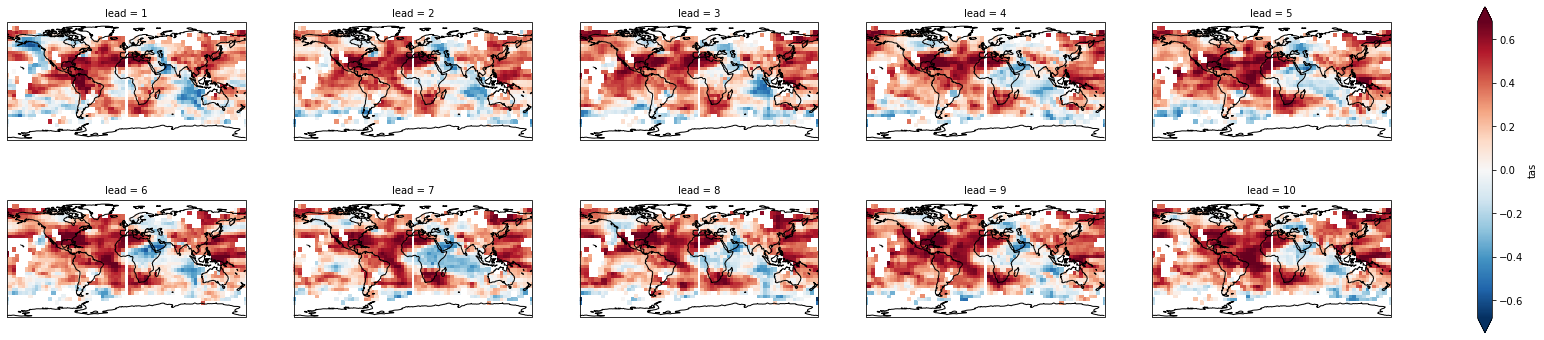

<IPython.core.display.Javascript object>

In [78]:
plot_skill(skill[variable_id])

In [73]:
import dask
if dask.is_dask_collection(hindcast.get_initialized()):
    %time skill = hindcast.verify(**cp_kwargs)
    display(skill[variable_id].data)
    %time skillc = skill.compute()

<IPython.core.display.Javascript object>

## Bootstrap significant skill

In [79]:
iterations=10

<IPython.core.display.Javascript object>

In [80]:
%time bskill = hindcast.bootstrap(iterations=iterations, **cp_kwargs)

CPU times: user 1.76 s, sys: 394 ms, total: 2.15 s
Wall time: 2.35 s


<IPython.core.display.Javascript object>

In [ ]:
improved_by_init = bskill.sel(results='p',kind='uninitialized') <= 0.05
plot_skill(improved_by_init[variable_id])

#### correct for FDR

In [ ]:
from esmtools.testing import multipletests
_, bskill_fdr_corr_p = multipletests(
    bskill.sel(skill="uninitialized", results="p"), method="fdr_bh", alpha=.05
)

improved_by_init_corr = bskill_fdr_corr_p <= .05
plot_skill(improved_by_init_corr[variable_id])

#### lazily with `dask`
when chunk by lead ~ 100mb

In [85]:
#hindcast = hindcast.chunk({'lead':-1, 'member':-1, 'init':-1, 'time':-1}).persist()
hindcast = HindcastEnsemble(hind_ym.chunk({'lead':-1, 'member':-1, 'init':-1})).add_uninitialized(hist_ym.chunk({'member':-1,'time':-1})).add_observations(obs_ym.chunk({'time':-1}))

hindcast.get_initialized()[variable_id].data

/srv/conda/envs/notebook/lib/python3.7/site-packages/climpred/utils.py:141: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  "Assuming annual resolution due to numeric inits. "


dask.array<rechunk-merge, shape=(5, 40, 10, 36, 72), dtype=float32, chunksize=(5, 40, 10, 36, 72), chunktype=numpy.ndarray>

<IPython.core.display.Javascript object>

In [86]:
%time bskill = hindcast.bootstrap(iterations=iterations, **cp_kwargs)

/srv/conda/envs/notebook/lib/python3.7/site-packages/climpred/checks.py:243: UserWarning: Chunking might not bring parallelized performance increase, because only few CPUs available, found 2 CPUs.
  f"Chunking might not bring parallelized performance increase, "


CPU times: user 1.36 s, sys: 15.1 ms, total: 1.37 s
Wall time: 1.45 s


<IPython.core.display.Javascript object>

In [87]:
bskill[variable_id].data

dask.array<concatenate, shape=(3, 10, 36, 72), dtype=float64, chunksize=(1, 1, 36, 72), chunktype=numpy.ndarray>

<IPython.core.display.Javascript object>

In [ ]:
%time bskillc = bskill.compute()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


#### Close down

In [ ]:
client.close()
cluster.close()

In [ ]:
regridder.clean_weight_file()